In [1]:
import torch
from torch import nn as nn
from torch import functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
f = lambda x : np.cos(np.pi/14*x) + np.sin(np.pi*x)

In [3]:
dataset = np.number([f(x)+0.5*np.random.randn() for x in np.arange(0, 100, 0.01)], dtype = np.float32)

In [4]:
N = len(dataset)
train_set = dataset[:int(0.8*N)]
test_set = dataset[int(0.8*N):]

In [5]:
class ts_dataset(Dataset):
    def __init__(self, dataset, lag = 128, horizon = 1):
        self.dataset = dataset
        self.lag = lag
        self.horizon = horizon
    def __len__(self):
        return len(self.dataset) - (self.lag+self.horizon) + 1
    def __getitem__(self, i):
        return self.dataset[i:i+self.lag], self.dataset[i+self.lag:i+self.lag+self.horizon]

In [6]:
train = ts_dataset(train_set)
test = ts_dataset(test_set)

In [7]:
train_t = DataLoader(train, batch_size = 16, shuffle = True, )
test_t = DataLoader(test, batch_size = 16, shuffle = True, )

In [8]:
M, (h, c) = nn.LSTM(1, 128, batch_first = True)(torch.randn(2, 10, 1))

In [9]:
h.shape, M.shape

(torch.Size([1, 2, 128]), torch.Size([2, 10, 128]))

In [10]:
h.permute(-2,0,-1).shape

torch.Size([2, 1, 128])

In [11]:
class model(nn.Module):
    def __init__(self, intermediate_dim = 128, n_heads = 4):
        super().__init__()
        self.lstm = nn.LSTM(1, intermediate_dim, batch_first = True)
        self.dense = nn.Linear(intermediate_dim,1)
        self.att_head = nn.MultiheadAttention(intermediate_dim, n_heads, batch_first = True)
    def forward(self, x):
        states, (h,c) = self.lstm(x)
        att_states, _ = self.att_head(states, h.permute(-2,0,-1), h.permute(-2,0,-1))
        x = self.dense(att_states[:, -1,:])
        return x
torch.manual_seed(5)
Model = model(128)
optimizer = torch.optim.SGD(Model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
running_train_loss = 1e-2
running_test_loss = 1e-2
    
for epoch in range(100):
    for i, (X,y) in enumerate(train_t):
        Model.train()
        optimizer.zero_grad()
        loss = torch.nn.MSELoss()(Model(X.unsqueeze(-1)),y)
        loss.backward()
        optimizer.step()
        running_train_loss += (loss.item()- running_train_loss)/(i+1)
        if i % 100 == 0:
            print(epoch, i,running_train_loss)

    
    with torch.no_grad():
        Model.eval()
        for i, (X,y) in enumerate(test_t):
            optimizer.zero_grad()
            loss = torch.nn.MSELoss()(Model(X.unsqueeze(-1)),y)
    
            running_test_loss += (loss.item()- running_test_loss)/(i+1)
            if i % 100 == 0:
                print(epoch, i,running_train_loss)


0 0 0.14362360537052155
0 100 0.31478861844775696
0 200 0.30724450675260945
0 300 0.3033165795809009
0 400 0.2989307037203982
0 0 0.2989834884893361
0 100 0.2989834884893361
1 0 0.3431188464164734
1 100 0.27990682061650946
1 200 0.2931729687461211
1 300 0.2938711649654709
1 400 0.296584167645459
1 0 0.29856955920293093
1 100 0.29856955920293093
2 0 0.21153698861598969
2 100 0.30488706512911495
2 200 0.30326721880269863
2 300 0.301480253421983
2 400 0.2950689467111432
2 0 0.2979544178257146
2 100 0.2979544178257146
3 0 0.47254106402397156
3 100 0.2661994376247474
3 200 0.2855357352773941
3 300 0.29210486522940693
3 400 0.2969842311598711
3 0 0.29752573528425474
3 100 0.29752573528425474
4 0 0.33239299058914185
4 100 0.29478415241926026
4 200 0.29785768947198016
4 300 0.3039909647251679
4 400 0.2991894993401527
4 0 0.2970337931642206
4 100 0.2970337931642206
5 0 0.5835139751434326
5 100 0.29709022388894957
5 200 0.2944390572125641
5 300 0.2928766745616037
5 400 0.2971950178951993


In [ ]:
Model(torch.tensor(test[1][0]).unsqueeze(0).unsqueeze(-1))

In [13]:
y_pred = np.number([Model(torch.tensor(test[i][0]).unsqueeze(0).unsqueeze(-1)).squeeze().detach().numpy() for i in range(len(test))])


In [14]:
y_test = np.number([test[i][1] for i in range(len(test))]).squeeze()

In [ ]:
from matplotlib import pyplot as plt

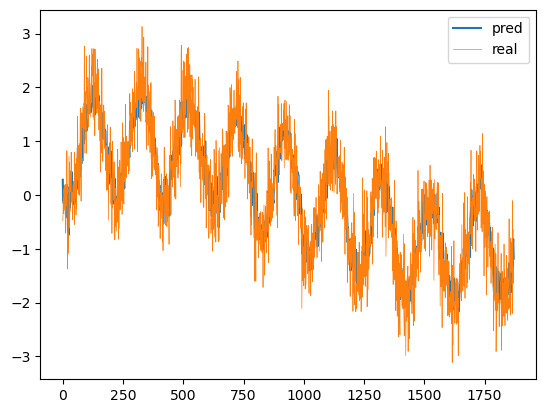

In [19]:
plt.plot(y_pred, label = "pred")
plt.plot(y_test, label = "real", linewidth=.5)
plt.legend()
plt.show()
### Yerli ve milli --- Domestic and National ChatGPT